In [9]:
import os
import torch
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from torchvision import models, transforms
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# Custom GradCAM class
import GradCam

In [10]:
# Directory structure
data_dir = 'flowers'
classes = ['rose', 'sunflower']

# Transformation for ResNet input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Load ResNet model for feature extraction
original_resnet_model = models.resnet50(pretrained=True)
resnet_model = torch.nn.Sequential(*list(original_resnet_model.children())[:-1])

c:\Users\patri\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patri\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [12]:
# Function to extract embeddings
def get_embedding(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        embedding = model(image).squeeze().numpy()
    return embedding

In [13]:
# Lists to store embeddings and labels
embeddings = []
labels = []
file_paths = []

# Extract embeddings for all images
for label_idx, label_name in enumerate(classes):
    folder_path = os.path.join(data_dir, label_name)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            embedding = get_embedding(img_path, resnet_model, transform)
            embeddings.append(embedding)
            labels.append(label_idx)
            file_paths.append(img_path)
        except Exception as e:
            print(f"Could not process image {img_path}: {e}")

In [14]:
# Convert to numpy arrays
embeddings = np.array(embeddings)
labels = np.array(labels)

In [15]:
# Split the embeddings and labels for training and validation
X_train, X_val, y_train, y_val, paths_train, paths_val = train_test_split(
    embeddings, labels, file_paths, test_size=0.2, random_state=42, stratify=labels
)

In [21]:
# Train a Random Forest classifier on embeddings
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# Validate the classifier
y_pred = rf_clf.predict(X_val)
print("Accuracy on validation set:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=classes))

Accuracy on validation set: 0.9769736842105263
              precision    recall  f1-score   support

        rose       0.97      0.98      0.98       157
   sunflower       0.98      0.97      0.98       147

    accuracy                           0.98       304
   macro avg       0.98      0.98      0.98       304
weighted avg       0.98      0.98      0.98       304



In [18]:
# Select prototypes for each class using KMeans clustering
n_prototypes = 5
selected_prototypes = {label: [] for label in classes}

for label_idx, label_name in enumerate(classes):
    class_embeddings = embeddings[labels == label_idx]
    class_paths = np.array(file_paths)[labels == label_idx]

    kmeans = KMeans(n_clusters=n_prototypes, random_state=42)
    kmeans.fit(class_embeddings)

    for cluster_center in kmeans.cluster_centers_:
        distances = np.linalg.norm(class_embeddings - cluster_center, axis=1)
        closest_idx = np.argmin(distances)
        selected_prototypes[label_name].append(class_paths[closest_idx])

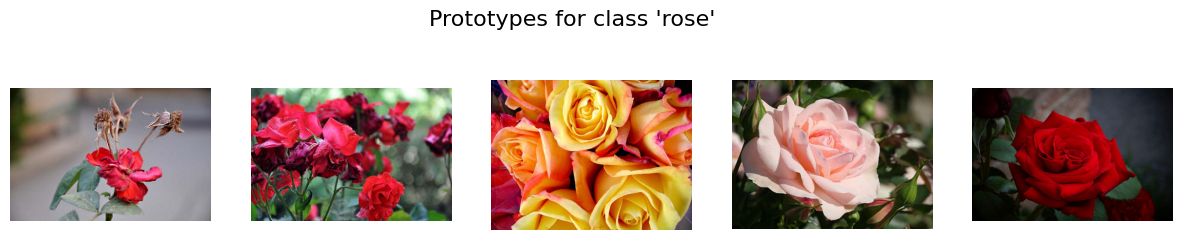

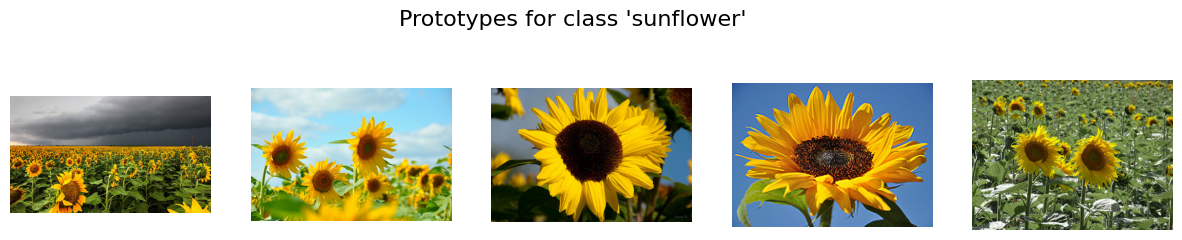

In [19]:
# Visualize prototypes
def visualize_prototypes(selected_prototypes, grid_size=(1, 5)):
    for label, prototypes in selected_prototypes.items():
        n_prototypes = len(prototypes)
        rows, cols = grid_size if n_prototypes >= grid_size[1] else (1, n_prototypes)
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3), squeeze=False)
        fig.suptitle(f"Prototypes for class '{label}'", fontsize=16)
        
        for idx, prototype_path in enumerate(prototypes):
            image = Image.open(prototype_path)
            if rows == 1:
                ax = axes[0, idx]
            else:
                ax = axes[idx // cols, idx % cols]
            ax.imshow(image)
            ax.axis('off')
        
        plt.show()

visualize_prototypes(selected_prototypes)

c:\Users\patri\Python\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


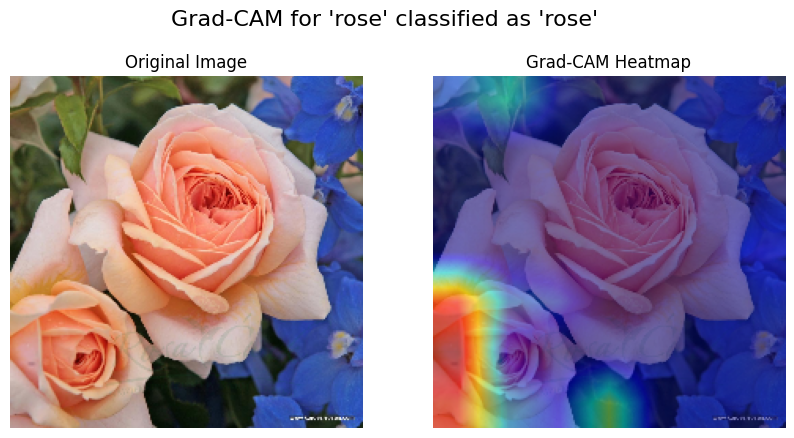

c:\Users\patri\Python\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


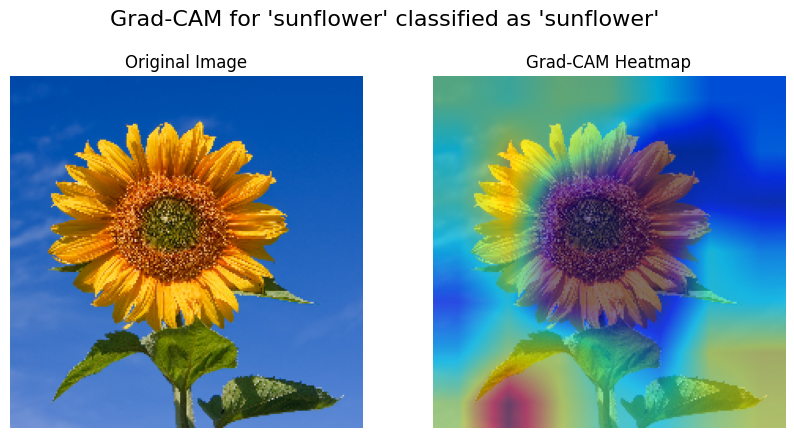

In [20]:

# Grad-CAM setup for visualization
grad_cam = GradCam.GradCAM(model=original_resnet_model, target_layer=original_resnet_model.layer4[-1])


# Test images
test_images = {
    'rose': 'test_images/rose.jpg',
    'sunflower': 'test_images/sunflower.jpg',
}

# Visualize Grad-CAM
for label, img_path in test_images.items():
    image_tensor = transform(Image.open(img_path).convert('RGB')).unsqueeze(0)
    with torch.no_grad():
        embedding = resnet_model(image_tensor).squeeze().numpy()
        class_idx = rf_clf.predict([embedding])[0]  # Predict class from Random Forest
        predicted_label = classes[class_idx]

    # Generate Grad-CAM heatmap
    cam = grad_cam(image_tensor, class_idx)

    # Overlay heatmap
    original_image = cv2.resize(cv2.imread(img_path), (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_image, 0.5, heatmap, 0.5, 0)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Grad-CAM for '{label}' classified as '{predicted_label}'", fontsize=16)

    plt.subplot(1, 2, 1)
    plt.imshow(original_image[..., ::-1])  # Convert BGR to RGB for display
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay[..., ::-1])  # Convert BGR to RGB for display
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.show()
